## Nelder Mead Algorithm

Nelder Meade is a simplex algorithm that takes $N+1$ points where $N$ is the number of dimensions in the space. Each iteration, one of the vertices is replaced by a point with a lower function value. Given the set of points $[x_1, x_2,...x_{N+1}]$ that satisfy $f(x_1) \leq f(x_2) \leq \  ...  \leq f(x_{N+1})$ the Nelder Meade algorithm is the following.

1. Calculate the mean of the first N points; $\text{centroid} = \frac{1}{N}\sum_{i=1}^{N}x_i$
2. Our first guess is the reflection of the worst point over the centroid; $\text{x}_\text{reflection} = \text{centroid} + \delta (\text{centroid} - x_{N+1})$ If delta is equal to one, this is a reflection, but it can be a different value. The function is evaluated at this point. If $f(x_1) \leq f(\text{x}_\text{reflection}) \leq f(x_{N})$, replace $x_{N+1}$ with $\text{x}_\text{reflection}$.
3. If $f(\text{x}_\text{reflection}) \leq f(x_1)$, then calculate $\text{x}_\text{expansion} = \text{centroid} + \text{expansion} (\text{centroid} -\text{x}_\text{reflection})$. This point is colinear with the reflected point, just extended out farther. If $f(\text{x}_\text{expansion}) \leq f(\text{x}_\text{reflection})$, replace $x_{N+1}$ with $\text{x}_\text{expansion}$. Otherwise, replace $x_{N+1}$ with $\text{x}_\text{reflection}$.
4. If $f(x_{N}) \leq f(\text{x}_\text{reflection}) \leq f(x_{N+1})$, compute the outer contraction point $\text{x}_\text{outer} = \text{centroid} - \text{contraction} (\text{centroid} -\text{x}_\text{reflection})$. If $f(\text{x}_\text{outer}) \leq f(\text{x}_\text{reflection})$, replace $x_{N+1}$ with $\text{x}_\text{outer}$. Otherwise go to 6.
5.  If $f(\text{x}_\text{reflection}) \geq f(x_{N+1})$, compute the inner contraction point $\text{x}_\text{inner} = \text{centroid} - \text{contraction} (\text{centroid} -\text{x}_{N+1})$. If $f(\text{x}_\text{inner}) \leq f(\text{x}_{N+1})$, replace $x_{N+1}$ with $\text{x}_\text{inner}$. Otherwise go to 6.
6. In this step, we restart the algorithm by shrinking the simplex. Replace all points except the closest point with $x_i = x_i - \text{shrink}(x_1 - x_i)$

The goal of Nelder Mead is to find the minimum with the minimum number of function evalutaions. Each loop takes either one or two evaluations unless a shrink must be performed. The code below implements the method and a method that plots a gif of the progression.


In [71]:
using  LinearAlgebra
using CairoMakie

struct Pointy
    x::Vector{Float64}
    value::Float64
    f::Function
end

Pointy(x, f) = Pointy(x,f(x),f)


function genPointy(coords::Vector{Vector{Float64}}, f::Function)
    vector_pointies = Vector{Pointy}(undef,length(coords))
    for i in 1:length(coords)
        vector_pointies[i] = Pointy(coords[i],f)
    end
    return vector_pointies
end

function centroid(sorted_vec_pointies::Vector{Pointy})
    center_vec = sorted_vec_pointies[1].x
    num_points = length(sorted_vec_pointies)
    for i in 2:num_points-1
        center_vec += sorted_vec_pointies[i].x
    end
    return Pointy(1/(num_points-1) * center_vec, sorted_vec_pointies[1].f)
end

function ex(x::Vector)
    k = sum(x .* x)
    return exp(k)
end

function nelder_mead(points::Vector{Vector{Float64}},f::Function;reflection::Float64 = 1.0, contraction::Float64 = 0.5, expansion::Float64 = 2.0, shrink::Float64 = 0.5, max_evals::Int64 = 500)
    
    #Make sure input is valid
    if length(points) != length(points[1]) + 1
        return "Error: Invalid number of Points. Number of points needs to be exactly one more than the dimensions of the function" 
    end

    #Declare all needed variables and sort vector
    func_evals = 0 
    dimensions = length(points) - 1
    points = genPointy(points, f)
    sort!(points; by=(x) -> x.value)
    func_evals += dimensions + 1
    j = 0
    while func_evals <= max_evals
       center = centroid(points)
       #reflection
       new_point_reflected = center.x + reflection*(center.x - points[end].x)
       reflected_pointy = Pointy(new_point_reflected, f)
       func_evals += 1
       if reflected_pointy.value >= points[1].value && reflected_pointy.value <= points[end].value
            #insert into array
            for i in 1:length(points)
                if points[i].value >= reflected_pointy.value
                    insert!(points, i, reflected_pointy)
                    pop!(points)
                    break
                end
            end
        #expansion if the new point is the  best point
        elseif reflected_pointy.value <= points[1].value
            new_point_ex = center.x + expansion * (center.x - reflected_pointy.x)
            exp_pointy = Pointy(new_point_ex,f)
            func_evals += 1
            if exp_pointy.value < reflected_pointy.value
                #insert exp
                insert!(points,1,exp_pointy)
                pop!(points)
            else
                #insert reflected
                insert!(points,1,reflected_pointy)
                pop!(points)
            end
        #Contractions
        else
            new_point_out = center.x - contraction * (center.x - reflected_pointy.x)
            new_point_in = center.x - contraction * (center.x - points[end].x)
            insert_bool = true
            if reflected_pointy.value < points[end].value && reflected_pointy.value > points[end-1].value
                out_pointy = Pointy(new_point_ex,f)
                func_evals += 1
                if out_pointy.value < reflected_pointy.value  
                    for i in 1:length(points)
                        if points[i].value >= out_pointy.value
                            insert!(points, i, out_pointy)
                            pop!(points)
                            break
                        end
                    end
                else
                    insert_bool = false
                end
            else
                in_pointy = Pointy(new_point_in,f)
                func_evals += 1
                if in_pointy.value < points[end].value  
                    for i in 1:length(points)
                        if points[i].value >= in_pointy.value
                            insert!(points, i, in_pointy)
                            pop!(points)
                            break
                        end
                    end
                else
                    insert_bool = false
                end

            end
            #shrink
            if insert_bool == false
                coords = map((x)-> points[1].x - shrink * (points[1].x - x.x), points)
                points = genPointy(coords, f)
                sort!(points; by=(x) -> x.value)
                func_evals += dimensions + 1
            end
        end
    j+=1
    end
    return points
end

function pointy_to_vec(p::Pointy)
    return p.x
end

function track(f::Function, points::Vector{Vector{Float64}};reflection::Float64 = 1.0, contraction::Float64 = 0.5, 
        expansion::Float64 = 2.0, shrink::Float64 = 0.5, max_evals::Int64 = 50,simplex_method::Function = nelder_mead)

    simplexes = Vector{Vector{Pointy}}(undef, max_evals)
    points = genPointy(points, f)
    simplexes[1] = points
    num_points = length(points) 
    
    for i in (2:max_evals)
        simplexes[i] = simplex_method(pointy_to_vec.(simplexes[i-1]), f;reflection = reflection, contraction = contraction, expansion = expansion, shrink = shrink, max_evals = num_points + 1)
    end
    
    return simplexes
end

function plot_x(f::Function, points::Vector{Vector{Float64}}, path::String;reflection::Float64 = 1.0, contraction::Float64 = 0.5, 
        expansion::Float64 = 2.0, shrink::Float64 = 0.5, max_evals::Int64 = 15, simplex_method::Function = nelder_mead, func_string = "Nelder Mead")
    
    if length(points) != 3 || length(points[1]) != 2
        return "Error: Invalid Points. Need 3 2D points" 
    end
    
    history = track(f,points; reflection = reflection, contraction = contraction, expansion = expansion, shrink = shrink, max_evals = max_evals, simplex_method = simplex_method)
    
    f = Figure()
    obs = Observable{Int64}(1)
    ax = Axis(f[1,1], title = @lift("$(func_string), iteration = $($obs)"))
    simplex = @lift(Point2f[history[$obs][1].x, history[$obs][2].x, history[$obs][3].x])
    poly!(simplex)
    
    #define the framerate
    framerate::Int64 = 1

    #Create GIF
    record(f, path, 1:max_evals; framerate = framerate) do t
    obs[] = t
    end
 
    if path[end-3:end] == ".gif"
        display(MIME"image/png"(), read(open(path)))
    end
end

function test(a::Int64)
    arr = Vector{Vector{Float64}}(undef, a+1)
    for i in 1:a+1
        arr[i] = 2 .* (rand(Float64, a) .- 1)
    end
    display(arr)
    return nelder_mead(arr, ex)
end

test (generic function with 1 method)

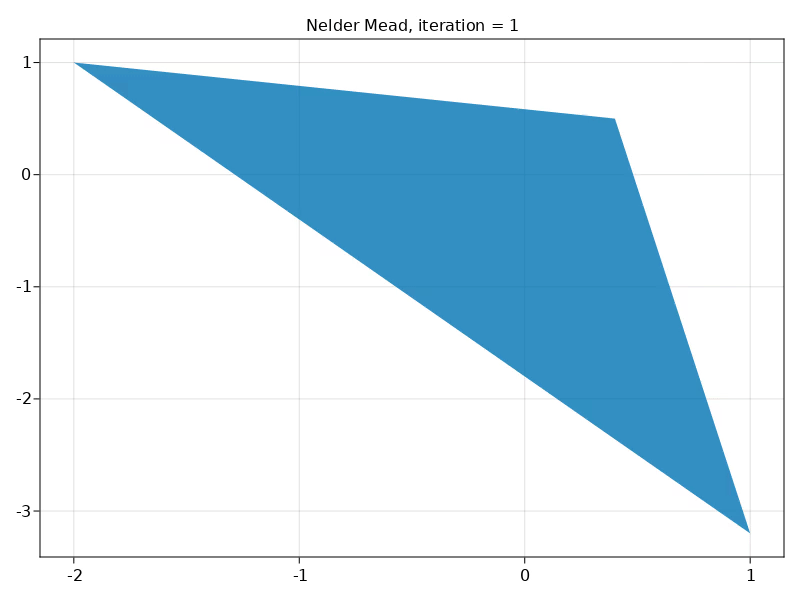

In [5]:
plot_x(ex,[[-2.0,1.0],[0.4,0.5], [1.0,-3.2]], "nelder.gif")

### Convergence

Unlike the other methods that have been discussed, there are no guarantees on nelder mead's convergence for smooth functions. In situation where this occurs, the algorithm will stagnate at unoptimal points. However, if the gradient is lipshcitz, then we are guaranteed local convergence. In practice, Nelder mead will frequently converge to the optimal point. 

## Mutli-Directional Search (MDS)

This is a similar method to nelder mead. However, the simplexes are made in such a way that they are all similar. Instead of adding one new point, we will maintain only one point from the previous simplex. The steps are as follows.

1. For 2:N+1, $r_j =x_1−\delta(x_j−x_1)$. If the new minimum is one of the reflected point, perform an expansion. Otherwise, perform a contraction.
2. Expansion: For 2:N+1, $e_j =x_1−\mu_e(x_j−x_1)$. If the minimum of the expansion is less than the minimum of the reflection, accept the expansion simplex. Otherwise, accept the reflection simplex.
3. Contraction:  For 2:N+1, $e_j =x_1−\mu_c(x_j−x_1)$


In [73]:
struct Simplex
    x::Vector{Pointy}
    function Simplex(x::Vector{Pointy})
        sort!(x; by = (x)->x.value)
        new(x)
    end
end

function reflect_simplex(s::Simplex; delta::Float64 = 1.0)
    points = copy(s.x)
    #display(points)
    for i in 2:length(points)
        coord = s.x[i].x
        #println(coord)
        #println(s.x[1].x - delta * (coord - s.x[1].x))
        points[i] = Pointy(s.x[1].x - delta * (coord - s.x[1].x), s.x[1].f)
    end
    #display(points)
    return Simplex(points)
end

function contract_simplex(s::Simplex; mu::Float64 = 0.5)
    points = copy(s.x)
    for i in 2:length(points)
        coord = s.x[i].x
        points[i] = Pointy(s.x[1].x + mu * (coord - s.x[1].x), s.x[1].f)
    end
    return Simplex(points)
end

function mds(points::Vector{Vector{Float64}},f::Function;reflection::Float64 = 1.0, contraction::Float64 = 0.5, expansion::Float64 = 2.0, shrink::Float64 = 0.5, max_evals::Int64 = 500)
    
    #Make sure input is valid
    if length(points) != length(points[1]) + 1
        return "Error: Invalid number of Points. Number of points needs to be exactly one more than the dimensions of the function" 
    end

    #Declare all needed variables and sort vector
    func_evals = 0 
    dimensions = length(points) - 1
    points = genPointy(points, f)
    simplex = Simplex(points)

    func_evals += dimensions + 1
    while func_evals <= max_evals
       
        #reflection
       reflected_simplex = reflect_simplex(simplex; delta = reflection)
       func_evals += dimensions + 1

       #expansion
       if reflected_simplex.x[1].value < simplex.x[1].value
            expanded_simplex = reflect_simplex(simplex; delta = expansion)
            func_evals += dimensions + 1
            if reflected_simplex.x[1].value < expanded_simplex.x[1].value
                simplex = reflected_simplex
            else
                simplex = expanded_simplex
            end

        #Contractions
        else
            func_evals += dimensions + 1
            simplex = contract_simplex(simplex; mu = contraction)
        end
    end
    return simplex.x
end

mds (generic function with 1 method)

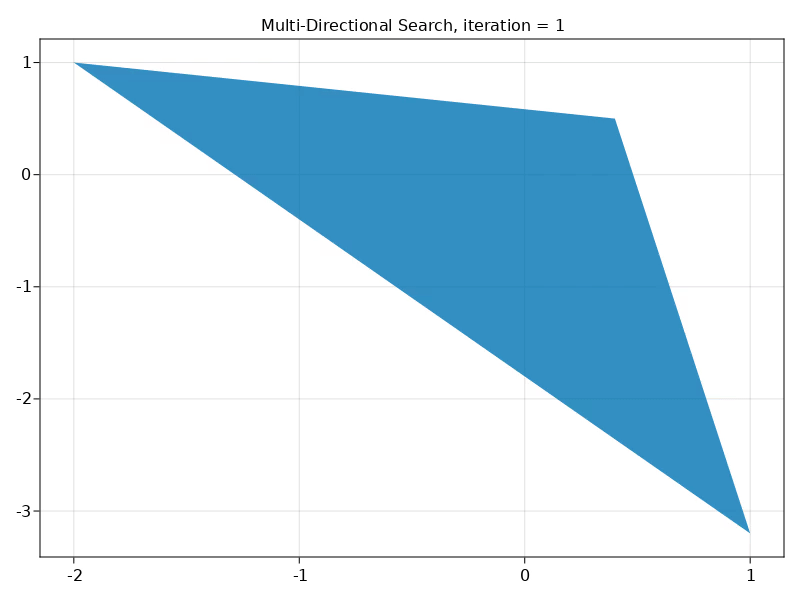

In [74]:
plot_x(ex,[[-2.0,1.0],[0.4,0.5], [1.0,-3.2]], "MDS.gif"; simplex_method = mds, func_string = "Multi-Directional Search")